In [1]:
import processing
import ds
import ml
import model_saving
import TS
import TA
# Load the necessary packages and modules
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import numpy as np
import math as m
import talib
import pickle

from hmmlearn.hmm import GaussianHMM
from sklearn.externals import joblib

Using TensorFlow backend.


##### importing different files of diffeerent day to crate test and train dataset. For prediction test

In [2]:
filename_test = '/home/octo/Dropbox'+ '/SPY22Dec.csv'

In [3]:
data=processing.get_csv_pd(filename_test)
data=processing.BA(data)
data=processing.preprocessing_mar(data)
data_km=ml.kalman_ma(data)
data['ckm']=data.Close-data_km
data['rsi']=talib.RSI(np.array(data.Close.astype('float64')))
data['atr']=talib.ATR(np.array(data.High.astype('float64')),np.array(data.Low.astype('float64')),np.array(data.Close.astype('float64')),timeperiod=20)
data['mom']=talib.MOM(np.array(data.Close.astype('float64')), timeperiod=5)
data=data.dropna()
data['ret']=np.log(data.Close/data.Close.shift(300))
data['AB']=np.where(np.log(data.Close/data.Close.shift(300))>0,1,-1)
data=data[7000:25000].dropna()

In [4]:
data=data.dropna()

##### Outlier points by saved model
##### Markov market state

In [5]:
filename_outlr = 'outlr.sav'
outlr_loaded = pickle.load(open(filename_outlr, 'rb'))
predictions_outlr = outlr_loaded.predict(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','spread','ckm', 'rsi', 'atr','mom']])
data['outlr']=predictions_outlr
hmm_loaded = joblib.load("markov_hmm.pkl")  
predictions_hmm = hmm_loaded.predict(data[['Volume','spread','ckm', 'rsi','UD']])
data['h_state']=predictions_hmm

    # for graph only 
    # inliers are labeled 1, outliers are labeled -1
    normal =data[predictions_outlr == 1]
    abnormal =data[predictions_outlr == -1]
    outlier_df=data.Close
    outlier_df['N']=normal.Close
    outlier_df['A']=abnormal.Close

#### for graph only 

In [6]:
# inliers are labeled 1, outliers are labeled -1
outlier_df=data[['Close','outlr']]
outlier_df['N']=outlier_df.Close[outlier_df.outlr== 1]
outlier_df['A']=outlier_df.Close[outlier_df.outlr== -1]

In [7]:
print(outlier_df.groupby('outlr').size())

outlr
-1.00000     4175
1.00000     13825
dtype: int64


In [8]:
print(outlier_df.groupby('outlr').describe()[['Close']])

               Close                                                  \
               count      mean     std       min       25%       50%   
outlr                                                                  
-1.00000  4175.00000 267.26746 0.12869 266.91501 267.17999 267.27499   
1.00000  13825.00000 267.30768 0.12664 266.91998 267.20001 267.31500   

                              
               75%       max  
outlr                         
-1.00000 267.33499 267.60498  
1.00000  267.37500 267.60498  


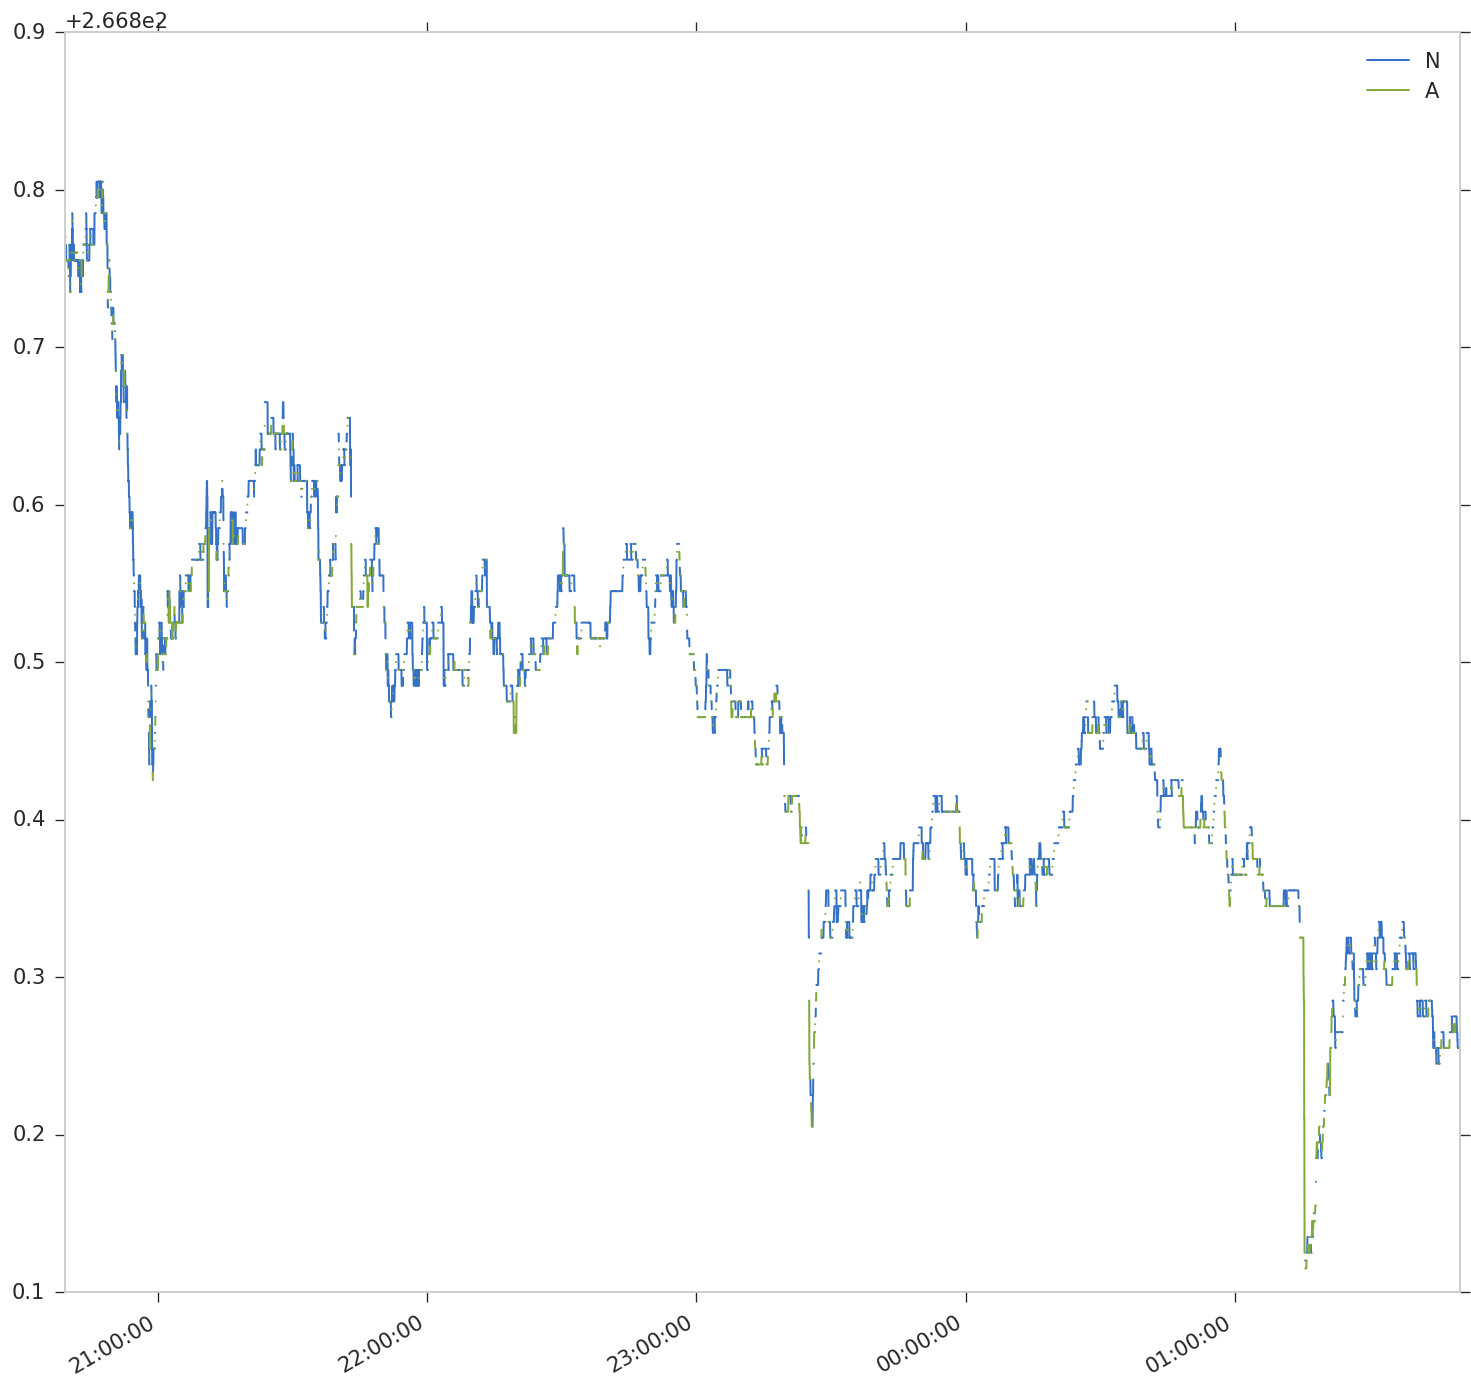

In [9]:
outlier_df[['N','A']].plot(figsize=(15,15))
plt.show()

In [10]:
print("Transition matrix")
print(hmm_loaded.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(hmm_loaded.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", hmm_loaded.means_[i])
    print("var = ", np.diag(hmm_loaded.covars_[i]))
    print()

Transition matrix
[[0.90129 0.02096 0.07775]
 [0.09576 0.90201 0.00223]
 [0.98693 0.      0.01307]]

Means and vars of each hidden state
0th hidden state
mean =  [216.39876  -0.00134   0.00027  51.49782   0.     ]
var =  [16198.36421     0.00002     0.00003  1056.83535     0.     ]

1th hidden state
mean =  [95.60883  0.00168 -0.00001 52.50588  0.     ]
var =  [ 739.56298    0.00001    0.00001 1022.26956    0.     ]

2th hidden state
mean =  [204.42775  -0.00073   0.00154  56.33113   0.23314]
var =  [21836.27392     0.00002     0.0001   1068.05093     0.92714]



In [11]:
from matplotlib import cm, pyplot as plt
def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(df)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components,
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask],
            df["spread"][mask],
            ".", linestyle='none',
            c=colour
        )
        #ax.set_title("Hidden State #%s" % i)
        #ax.xaxis.set_major_locator(YearLocator())
        #ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()

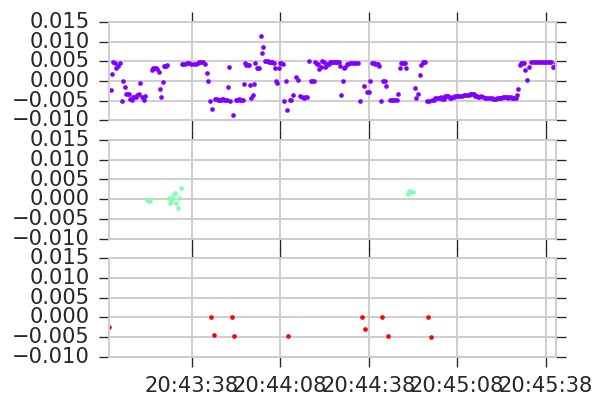

In [12]:
plot_in_sample_hidden_states(hmm_loaded,data[['Volume','spread','ckm', 'rsi','UD']][500:800])

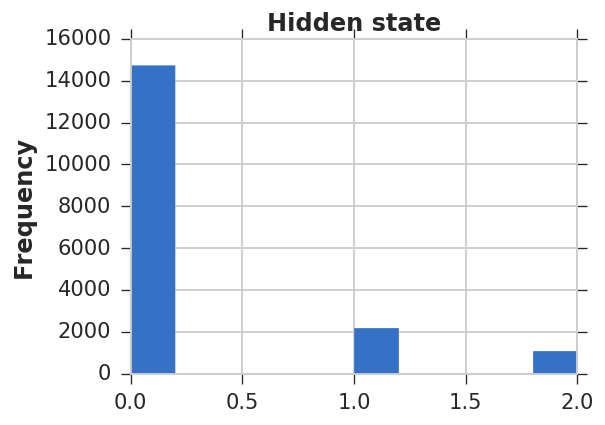

In [13]:
import matplotlib.pyplot as plt
data['h_state'].plot(kind='hist', grid=True, title='Hidden state')
plt.show()

In [14]:
# class distribution
print(data.groupby('h_state').size())

h_state
0    14743
1     2166
2     1091
dtype: int64


In [15]:
pd.crosstab(index=data.h_state,columns=data.UD) 

UD,-1,0,1
h_state,,,
0,0,14743,0
1,0,2166,0
2,565,80,446


In [16]:
pd.crosstab(index=data.h_state,columns=data.AB) 

AB,-1,1
h_state,,
0,8099,6644
1,1304,862
2,631,460


In [17]:
##### class distribution
print(data.groupby('h_state').describe()[['Close']])

              Close                                                            \
              count      mean     std       min       25%       50%       75%   
h_state                                                                         
0       14743.00000 267.30145 0.12969 266.92001 267.19501 267.30499 267.36499   
1        2166.00000 267.27148 0.10092 267.05499 267.19501 267.26501 267.32501   
2        1091.00000 267.28046 0.14278 266.91501 267.17499 267.29999 267.37000   

                   
              max  
h_state            
0       267.60498  
1       267.58499  
2       267.60498  


 #### Here not useful  
    data[['h_state','UD']].plot(figsize=(15,15))
    plt.show()

In [18]:
import numpy as np 
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot

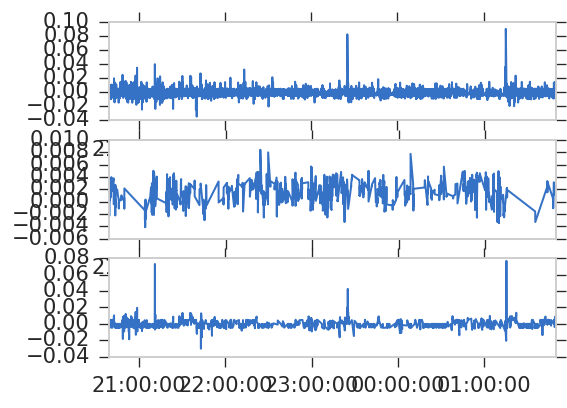

In [19]:
groups = data.spread.groupby(data.h_state)
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

# Abnormal data at state 0 will change state.

In [20]:
##### Processing Normal, Abnormal points NAP A=-1 and N=+1

In [21]:
data['NAP']=np.where(data.outlr*np.argmin(np.diag(hmm_loaded.transmat_))<1,-1,1)

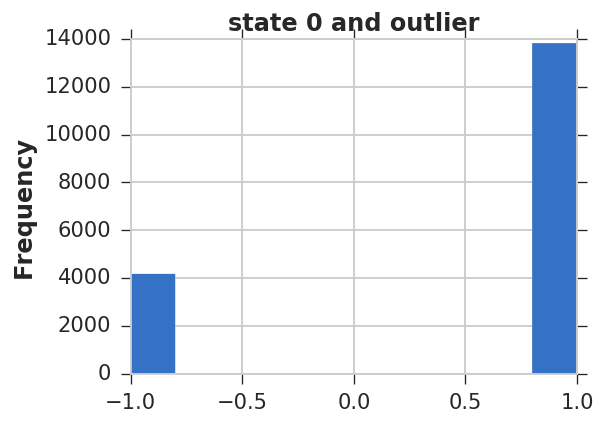

In [22]:
data.NAP.plot(kind='hist', grid=True, title='state 0 and outlier')
plt.show()

In [23]:
# class distribution
print(data.groupby('NAP').size())

NAP
-1     4175
 1    13825
dtype: int64


In [24]:
### Jump is for prediction. 

In [25]:
data['J']=np.where(data.UD==0,0,1)

In [26]:
# class distribution
print(data.groupby('J').size())

J
0    16989
1     1011
dtype: int64


### Saving dataset for model saving notebook

In [27]:
data.columns

Index(['askPrice', 'askSize', 'bidPrice', 'bidSize', 'Open', 'Close', 'High',
       'Low', 'Volume', 'spread', 'Up', 'Dn', 'UD', 'ckm', 'rsi', 'atr', 'mom',
       'ret', 'AB', 'outlr', 'h_state', 'NAP', 'J'],
      dtype='object')

In [28]:
data_save=data[['askPrice', 'askSize', 'bidPrice', 'bidSize', 'Open', 'Close', 'High',
       'Low', 'Volume', 'spread','ckm', 'rsi', 'atr', 'mom','AB','J','h_state','NAP']]

In [29]:
data_save.to_csv('/home/octo/Dropbox/for_ml_model.csv', sep=',', encoding='utf-8')

# Prediction

## Prediction of +1,-1, Direction

### Tree

In [30]:
filename_tree = 'model_tree.sav'
tree_loaded = pickle.load(open(filename_tree, 'rb'))
predictions_tree = tree_loaded.predict(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']])

In [31]:
tree_loaded.score(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']],data.AB)

0.6652777777777777

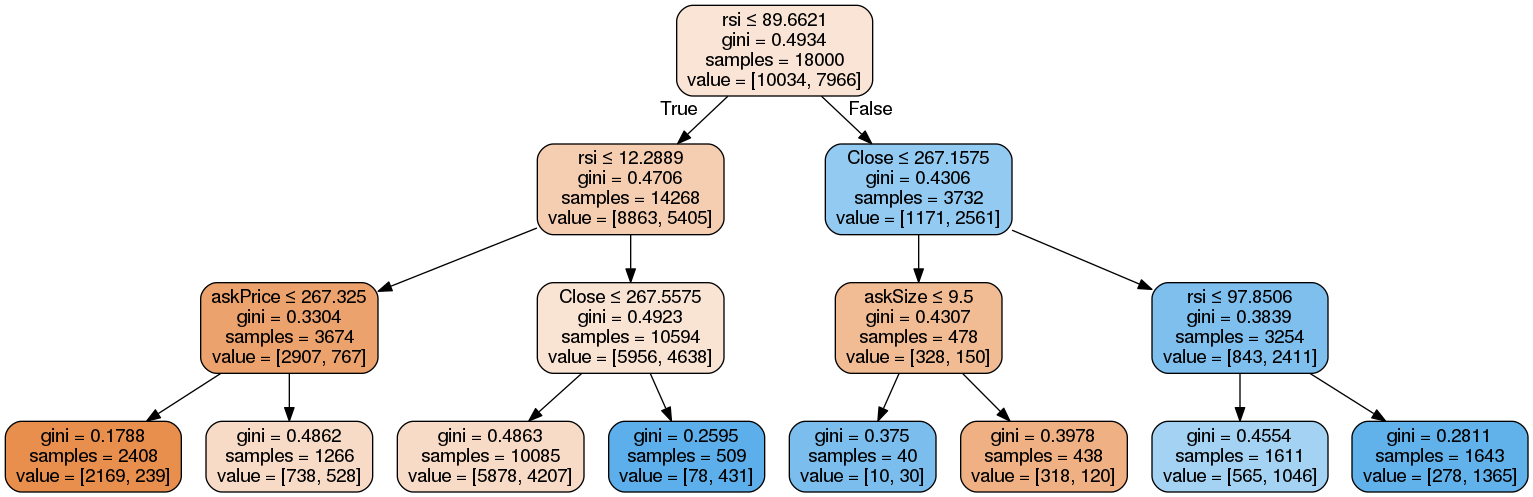

In [32]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_loaded, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']].columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### RF

In [33]:
filename_rf = 'model_rf.sav'
rf_loaded = pickle.load(open(filename_rf, 'rb'))
predictions_rf = rf_loaded.predict(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']])

In [34]:
rf_loaded.score(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']],data.AB)

0.9983888888888889

In [35]:
data['prAB']=predictions_rf

In [36]:
pd.crosstab(index=data.NAP,columns=data.prAB) 

prAB,-1.0,1.0
NAP,,
-1,2820,1355
1,7235,6590


In [37]:
# class distribution
print(data.groupby('prAB').size())

prAB
-1.00000    10055
1.00000      7945
dtype: int64


## Prediction of Jump

### Tree

In [38]:
filename_tree = 'j_tree.sav'
tree_loaded = pickle.load(open(filename_tree, 'rb'))
predictions_tree = tree_loaded.predict(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']])

In [39]:
tree_loaded.score(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']],data.J)

0.9438333333333333

In [40]:
data['prJ']=predictions_tree

In [41]:
# class distribution
print(data.groupby('prJ').size())

prJ
0.00000    18000
dtype: int64


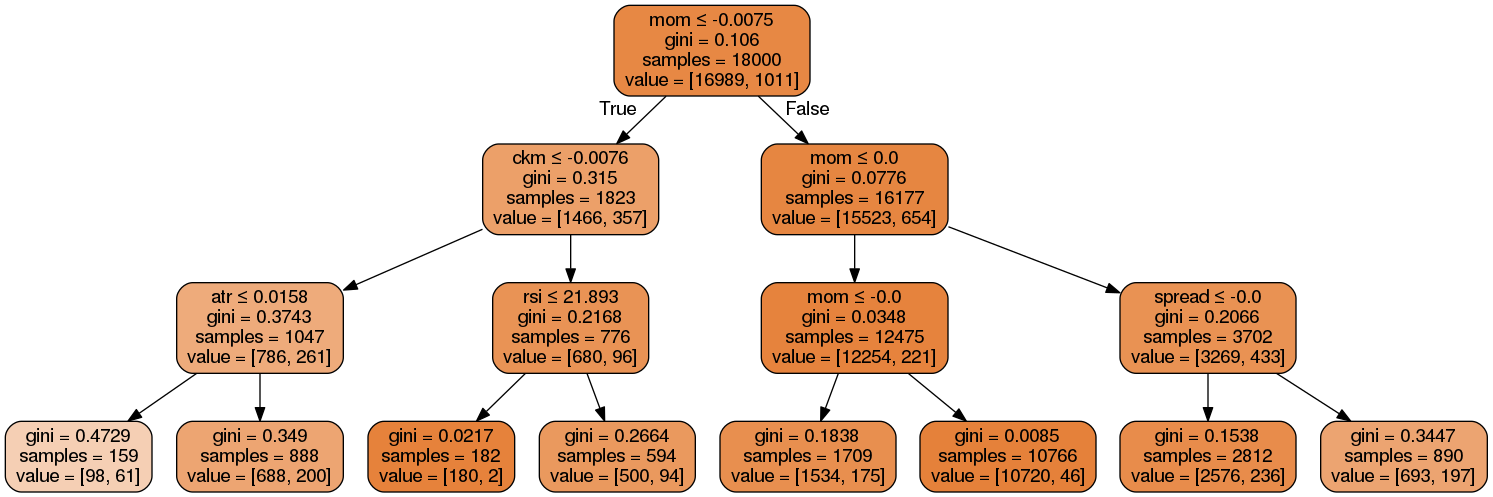

In [42]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_loaded, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']].columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### RF

In [43]:
filename_rf = 'j_rf.sav'
rf_loaded = pickle.load(open(filename_rf, 'rb'))
predictions_rf = rf_loaded.predict(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']])

In [44]:
rf_loaded.score(data[['askPrice', 'askSize', 'bidPrice', 'bidSize','Close','spread','ckm', 'rsi', 'atr', 'mom']],data.J)

0.9935555555555555

In [45]:
data['prJ']=predictions_rf

In [46]:
# class distribution
print(data.groupby('prJ').size())

prJ
0.00000    17103
1.00000      897
dtype: int64


In [47]:
pd.crosstab(index=data.NAP,columns=data.prJ) 

prJ,0.0,1.0
NAP,,
-1,3928,247
1,13175,650


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18000 entries, 2017-12-22 20:39:08.157436 to 2017-12-23 01:50:13.719414
Data columns (total 25 columns):
askPrice    18000 non-null float32
askSize     18000 non-null float32
bidPrice    18000 non-null float32
bidSize     18000 non-null float32
Open        18000 non-null float32
Close       18000 non-null float32
High        18000 non-null float64
Low         18000 non-null float64
Volume      18000 non-null float32
spread      18000 non-null float32
Up          18000 non-null int64
Dn          18000 non-null int64
UD          18000 non-null int64
ckm         18000 non-null float64
rsi         18000 non-null float64
atr         18000 non-null float64
mom         18000 non-null float64
ret         18000 non-null float32
AB          18000 non-null int64
outlr       18000 non-null float64
h_state     18000 non-null int64
NAP         18000 non-null int64
J           18000 non-null int64
prAB        18000 non-null float32
prJ         1800

In [83]:
data.head(3)

,askPrice,askSize,bidPrice,bidSize,Open,Close,High,Low,...,h_state,NAP,J,prAB,prJ,trade,diff,strat_ret
2017-12-22 20:41:29.898889,267.56000,10.00000,267.56000,3.00000,267.56000,267.56000,267.56000,267.54999,...,0,-1,0,1.00000,0.00000,0,0.00500,nan
2017-12-22 20:41:30.458270,267.56000,10.00000,267.54999,3.00000,267.55499,267.56000,267.56000,267.54999,...,0,-1,0,1.00000,0.00000,0,0.00500,nan
2017-12-22 20:41:31.023979,267.56000,10.00000,267.54999,269.00000,267.55499,267.55499,267.56000,267.54999,...,0,1,0,-1.00000,0.00000,0,0.00000,nan


### trade signal from classification

In [49]:
#trade=np.where(np.logical_and(data.NAP==-1,data.prJ==1),1,0)

In [50]:
#data['trade']=np.where(np.logical_and(trade==1,data.prAB==1),1,np.where(np.logical_and(trade==1,data.prAB==-1),-1,0))

In [51]:
# class distribution
print(data.groupby('trade').size())

trade
-1       95
 0    17753
 1      152
dtype: int64


### ARIMA

In [54]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

In [55]:
arima_loaded = ARIMAResults.load('arima.pkl')
prARIMA =arima_loaded.predict()

In [78]:
data=data[:len(prARIMA)]

In [56]:
#data.prAB=np.where(np.logical_and(ARIMA>0,data.prAB==1),1,np.where(np.logical_and(prARIMA<0,data.prAB==-1),-1,0))

In [57]:
#data['trade']=np.where(np.logical_and(trade==1,data.ARIMA+data.prAB>1),1,np.where(np.logical_and(trade==1,data.ARIMA*data.prAB<1),-1,0))

In [79]:
trade=data[['Close','NAP','prJ','prAB']].values

In [80]:
trade[:,1]

array([-1., -1.,  1., ...,  1.,  1.,  1.])

In [62]:
#arima = list()
#arima.append(prARIMA.values)

In [81]:
arima=prARIMA.values

In [82]:
len(trade)

17699

In [138]:
jump=np.where(np.logical_and(trade[:,2]==1,arima>0.003),1,np.where(np.logical_and(trade[:,2]==1,arima<-0.003),-1,0))

In [139]:
j_df=pd.DataFrame(jump)
j_df.columns=['jump']
print(j_df.groupby('jump').size())

jump
-1       55
 0    17595
 1       49
dtype: int64


In [140]:
ud=np.where(np.logical_and(trade[:,3]==1,arima>0.004),1,np.where(np.logical_and(trade[:,3]==-1,arima<-0.004),-1,0))

In [141]:
ud_nap=np.where(np.logical_and(trade[:,1]==-1,ud==1),1,np.where(np.logical_and(trade[:,1]==-1,ud==-1),-1,0))

In [142]:
ud_nap_df=pd.DataFrame(ud_nap)
ud_nap_df.columns=['ud']
print(ud_nap_df.groupby('ud').size())

ud
-1       54
 0    17621
 1       24
dtype: int64


In [145]:
signal=np.where(np.logical_or(jump==1,ud_nap==1),1,np.where(np.logical_or(jump==-1,ud_nap==-1),-1,0))

In [146]:
s_df=pd.DataFrame(signal)
s_df.columns=['signal']
print(s_df.groupby('signal').size())

signal
-1      108
 0    17522
 1       69
dtype: int64


In [159]:
final=pd.DataFrame(signal)
final.columns=['signal']

In [160]:
final['Close']=trade[:,0]

In [161]:
# class distribution
print(final.groupby('signal').size())

signal
-1      108
 0    17522
 1       69
dtype: int64


In [162]:
final.tail()

,signal,Close
17694,0,267.05499
17695,0,267.05499
17696,0,267.05499
17697,0,267.05499
17698,0,267.05499


## Backtest

In [164]:
# Creating trading strategy
final['ret']=np.log(final.Close/final.Close.shift(300))
cum_ret=final.ret.cumsum()*100
final['strat_ret']=final.ret*final.signal.shift(1)*100
cum_strat_ret=final.strat_ret.cumsum()

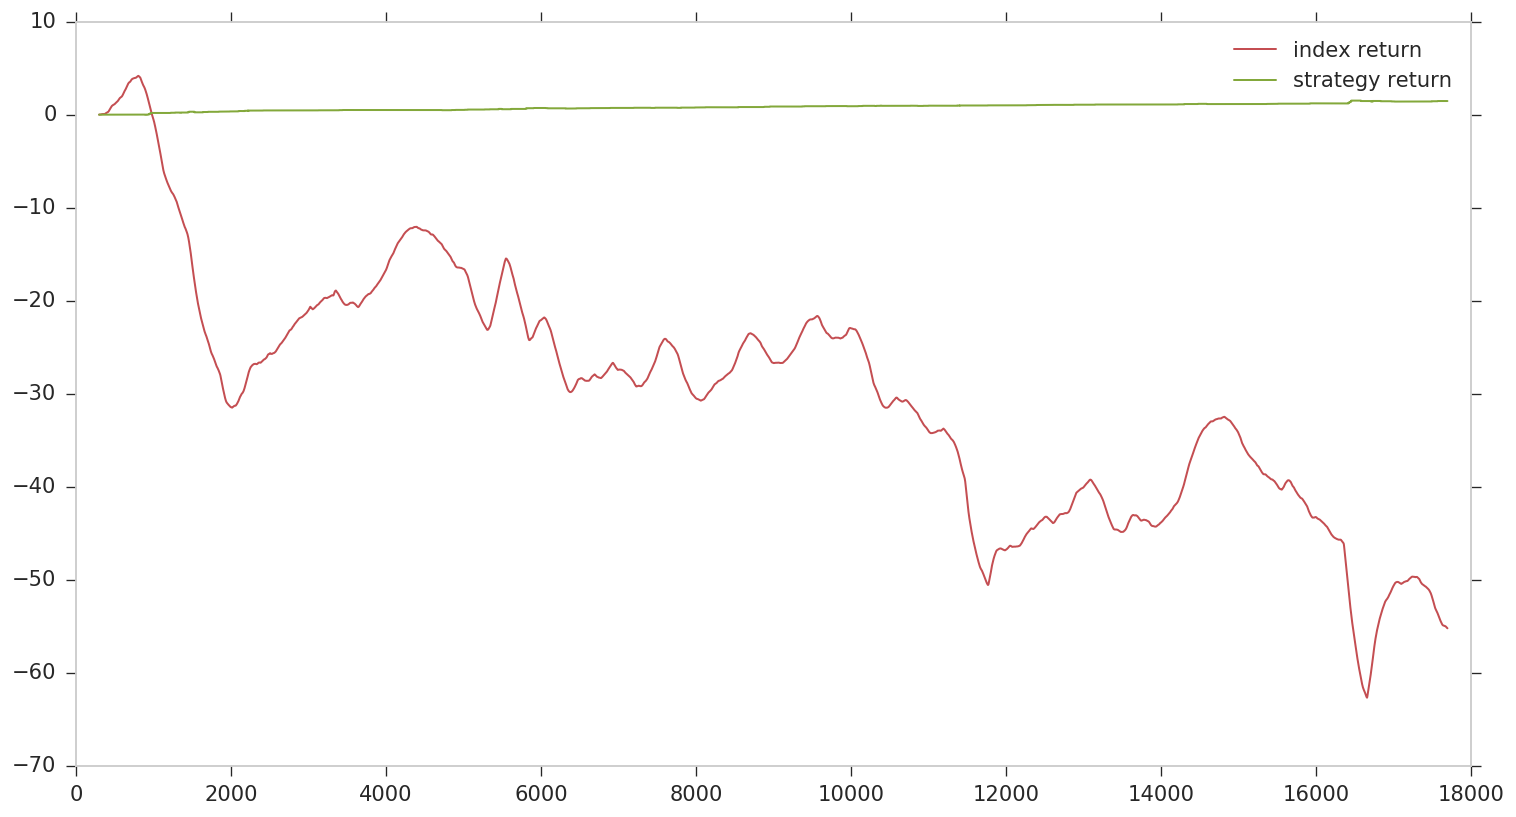

In [165]:
#plot
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(cum_ret,color='r',label='index return')
plt.plot(cum_strat_ret,color='g',label='strategy return')
plt.legend()
plt.show()